## Final Team BuzzFeed Predictor


### Step 1: Load Data and Clean it up
#### A. Features: Clean Null
#### B. Target: Normalize - use (freq, Impressions) and max_impressions
Use Viral, Non-Viral (Pick -1 Std. Dev. as an arbitrary marker)
Try Multiple Classes: 1 Buzz (Bottom quartile), 2 (Middle 50%) Buzz and 3(Top Quartile) Buzz
Final Application:  Two classes:  Viral and Non-Viral
### Step 2: Describe data
### Step 3: Select Features
Tried all the following ones
Final Application:  Combination of all Texts (Title, Description, Tags, Primary KW and Category
#### A. Combination of All Texts
#### B. Identify ones with signals
#### C. Remove infrequent terms
#### D. Remove too-frequent terms
#### E. Remove instances with time bias (News)
#### F.  Use tags and primary_kw phrases as tokens instead of breaking them apart (Convert String to List)
### Step 4: Modeling
#### Model Selection:  Multinomial NB, Logistic Regression, SVM (Maybe if we have time)
Final Application:  Multinomial NB and Logistic Regression
#### Hyperparameter tuning
### Step 5: Pipeline
#### Cross Validation
### Step 6: Feature Engineering and Reduction 
#### Try another model:  Length of title, Number of Tags, List or other description of the title
Final Application:  No signal in Lenght of title, List vs. non-list.  No new feature used.
#### Feature reduction (PCA, SVD)
Final Application:  Did not try.
#### Feature union
Final Application:  Did not try.
#### Weighted feature analysis - what is more important:  Title, Descr, Keywords, Tags
Final Application:  Did not try.
### Step 7: Other things to try:
#### A. Based upon articles that go viral in a country, impact of : source country, cats, keywords, etc. 
Final Application: Did not try methodically.

In [1]:
import os
import json
import time
import pickle
import requests
import math


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
# STEP 1
df = pd.DataFrame()
df = pd.read_csv('finaldata/alldata.csv', delimiter="|")

df = df.sample(frac=1).reset_index(drop=True)
# Cleanup Dummy/NaaN Values to keep from failing
df['primary_kw'].fillna(" ", inplace=True)
df['tags'].fillna(" ", inplace=True)
for i, row in df.iterrows():
    cv = df.iloc[i,10]
    # TRY USING PHRASES
    cv = cv.replace(" ", "_")
    cv = cv.replace("*", " ")
    df.set_value(i,'tags',cv)

9.85930986198
3.27098959759


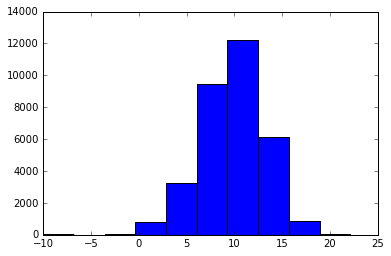

In [3]:
# Combine all text for use in CountVectorizer
df['AllText'] = ""
for i, row in df.iterrows():
    cv = df.iloc[i,5]+" "+df.iloc[i,6]+" "+df.iloc[i,7]+" "+df.iloc[i,9]+" "+df.iloc[i,10]
    df.set_value(i,'AllText',cv)

# Log to convert to Normal Distribution  
df['Log'] = df['freq']*(df['max_impres']+1)/1000
for i, row in df.iterrows():
    cv = math.log(df.iloc[i,12],2)
    df.set_value(i,'Log',cv)

# STEP 2: 
    
# Get mean to standard deviation to help separate viral and non-viral classes
data_mean = df["Log"].mean()
print data_mean
data_std = df["Log"].std()
print data_std
%matplotlib inline
plt.hist(df["Log"])
plt.show()

# Assign buzzes:  Used simply for readability, especially when assiging multiple classes
df['viral'] = ""
for i, row in df.iterrows():
    if df.iloc[i,12]<=(data_mean-data_std):
        df.set_value(i,'viral','0buzz')
    else:
        df.set_value(i,'viral','1buzz')

# Convert classes to numeric
df['viral_num'] = 0
df['viral_num'] = df.viral.map({'0buzz':0, '1buzz':1})

In [4]:
# STEP 3:  SEPARATE FEATURES AND TARGET VARIABLES
X = df.AllText
y = df.viral_num
# instantiate the vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [5]:
# STEP 4: MODELING
# STEP 5: PIPELINE

# instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vect, nb)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

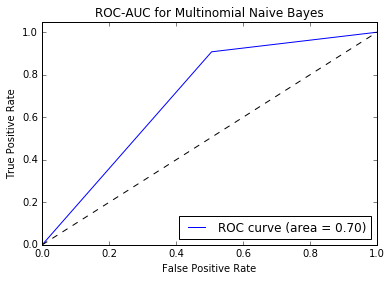

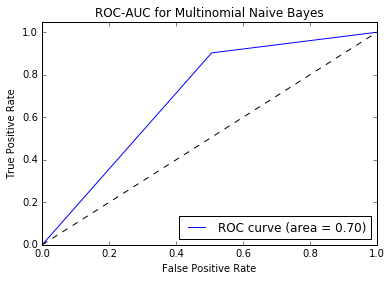

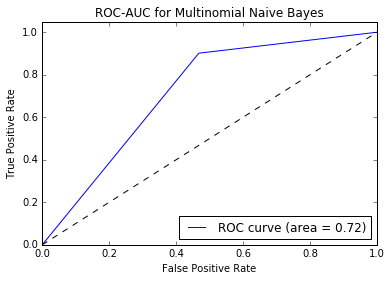

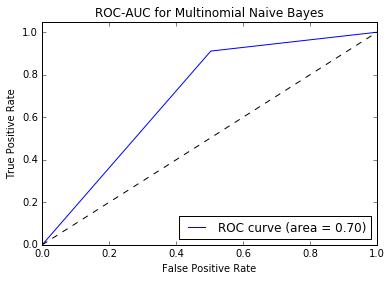

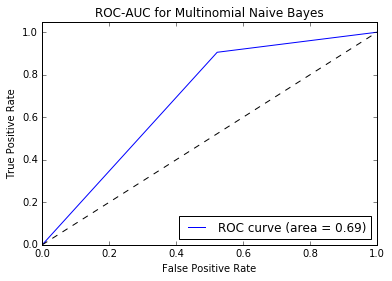

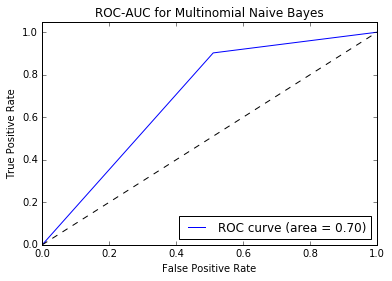

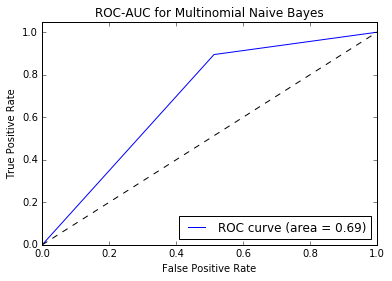

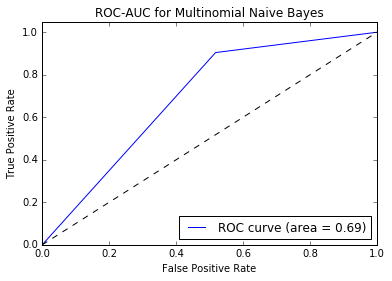

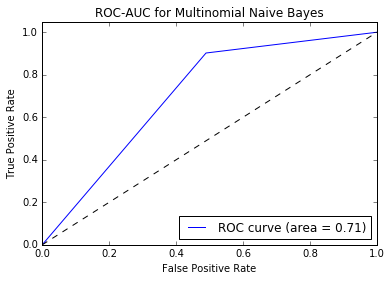

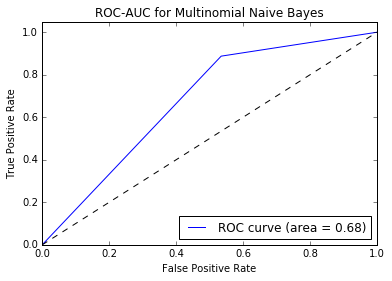

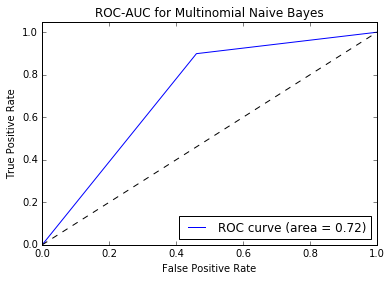

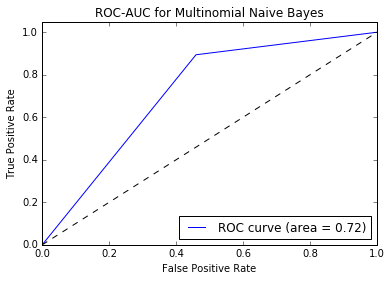


Build and Validation of took 28.010 seconds

Estimator Model: Multinomial Naive Bayes

Validation scores are as follows:

accuracy     0.839712
auc          0.700927
f1           0.904928
precision    0.908765
recall       0.901149
dtype: float64


In [6]:
from sklearn.cross_validation import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score

start  = time.time()
model_label = "Multinomial Naive Bayes"
#Train and test the model using StratifiedKFold cross validation. Compile the scores for each iteration of the model.
scores = {'accuracy':[], 'auc':[], 'f1':[], 'precision':[], 'recall':[]}


skf = StratifiedKFold(y, n_folds=12, shuffle=True) 
for train, test in skf:  
    #Anurag Code below   
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
        
    pipe.fit(X_train, y_train)
    expected  = y_test
    predicted = pipe.predict(X_test)
        
    ## Visualize scores  -- AUC IS FOR CLASSIFICATION MODEL ONLY
    fpr, tpr, thresholds = roc_curve(expected, predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for {}'.format(model_label))
    plt.legend(loc="lower right")
    plt.show()
        
    ## Record scores
    scores['accuracy'].append(accuracy_score(expected, predicted))
    scores['f1'].append(f1_score(expected, predicted, average='binary'))
    scores['precision'].append(precision_score(expected, predicted, average='binary'))
    scores['recall'].append(recall_score(expected, predicted, average='binary'))

    """
    AUC cannot be computed if only 1 class is represented in the data. When that happens, record an AUC score of 0.
    """
    try:
        scores['auc'].append(roc_auc_score(expected, predicted))
    except:
        scores['auc'].append(0)
        
    
print "\nBuild and Validation of took {:0.3f} seconds\n".format(time.time()-start)
print "Estimator Model: {}\n".format(model_label)
print "Validation scores are as follows:\n"
print pd.DataFrame(scores).mean()

In [7]:
# calculate accuracy of class predictions
from sklearn.cross_validation import cross_val_score
cross_val_score(pipe,X,y,cv=12,scoring='accuracy').mean()

0.83891794590890356

In [8]:
# import and instantiate a Logistic Regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vect, logreg)
pipe.steps

[('countvectorizer',
  CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
          dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 1), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

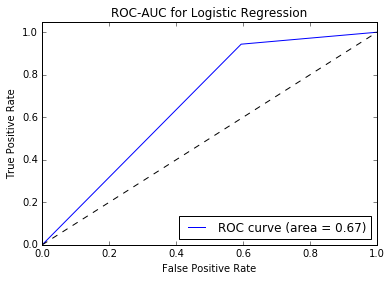

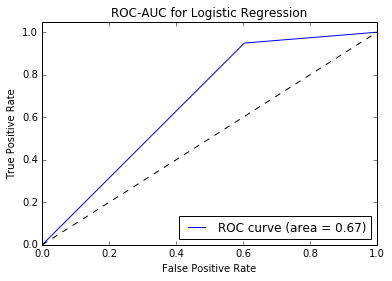

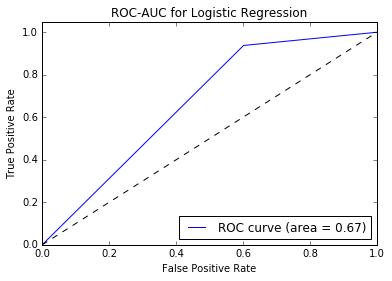

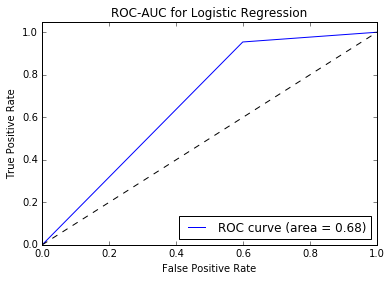

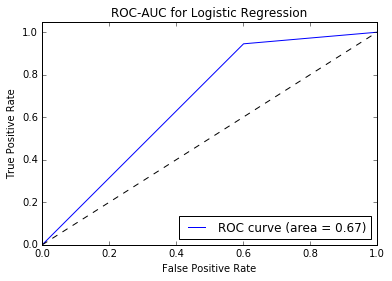

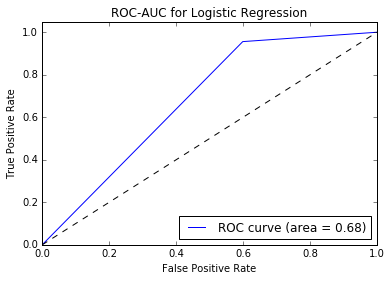

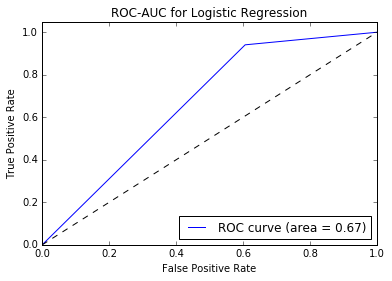

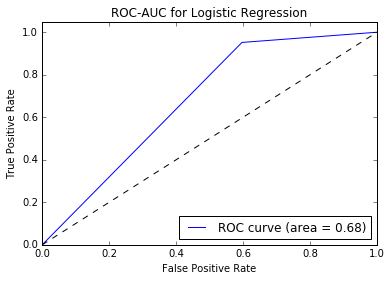

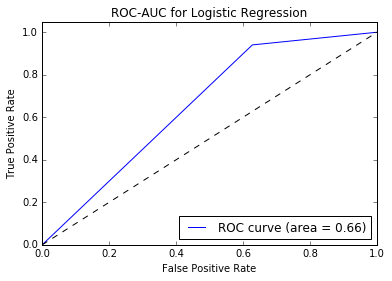

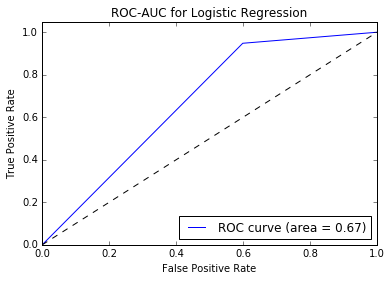

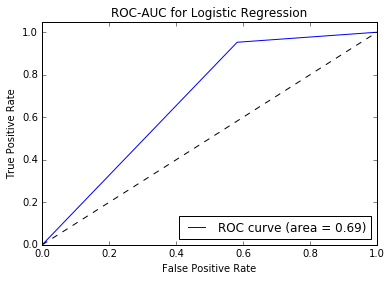

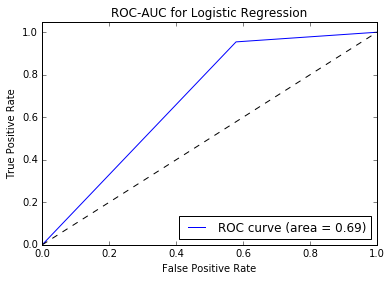


Build and Validation of took 48.648 seconds

Estimator Model: Logistic Regression

Validation scores are as follows:

accuracy     0.863945
auc          0.674356
f1           0.921842
precision    0.897214
recall       0.947872
dtype: float64


In [9]:
model_label = "Logistic Regression"
start  = time.time()
#Train and test the model using StratifiedKFold cross validation. Compile the scores for each iteration of the model.
scores = {'accuracy':[], 'auc':[], 'f1':[], 'precision':[], 'recall':[]}
skf = StratifiedKFold(y, n_folds=12, shuffle=True) 
for train, test in skf:  

    #Anurag Code below   
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y[train]
    y_test = y[test]
        
    pipe.fit(X_train, y_train)
    expected  = y_test
    predicted = pipe.predict(X_test)
        
    ## Visualize scores  -- AUC IS FOR CLASSIFICATION MODEL ONLY
    fpr, tpr, thresholds = roc_curve(expected, predicted)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC for {}'.format(model_label))
    plt.legend(loc="lower right")
    plt.show()
        
    ## Record scores
    scores['accuracy'].append(accuracy_score(expected, predicted))
    scores['f1'].append(f1_score(expected, predicted, average='binary'))
    scores['precision'].append(precision_score(expected, predicted, average='binary'))
    scores['recall'].append(recall_score(expected, predicted, average='binary'))

    """
    AUC cannot be computed if only 1 class is represented in the data. When that happens, record an AUC score of 0.
    """
    try:
        scores['auc'].append(roc_auc_score(expected, predicted))
    except:
        scores['auc'].append(0)

print "\nBuild and Validation of took {:0.3f} seconds\n".format(time.time()-start)
print "Estimator Model: {}\n".format(model_label)
print "Validation scores are as follows:\n"
print pd.DataFrame(scores).mean()


In [10]:
# calculate accuracy of class predictions
cross_val_score(pipe,X,y,cv=12,scoring='accuracy').mean()

0.86556170453255354

In [11]:
print ("MEAN", data_mean)
print ("STD DEV", data_std)
print ("NON-VIRAL", data_mean - data_std)
print ("CLASS COUNTS")
df.viral.value_counts()

('MEAN', 9.8593098619827284)
('STD DEV', 3.2709895975928229)
('NON-VIRAL', 6.588320264389905)
CLASS COUNTS


1buzz    27739
0buzz     5027
Name: viral, dtype: int64